**Mount Google Drive & Install Required Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pydicom opencv-python numpy


**Define Paths and Convert DICOM to PNG**

In [ ]:
import os
import pydicom
import cv2
import numpy as np

# "It is the main dircetory which contains patient CT scan data"
root_directory = "/content/drive/MyDrive/SAMPLED DATASET/manifest-1600709154662/LIDC-IDRI"
# "we need a separate folder to store all the converted PNG images."
output_directory = "processed_images"

In [ ]:
# Function to Convert DICOM to PNG
def dicom_to_png(dicom_path, output_path):
    try:
        dicom_data = pydicom.dcmread(dicom_path)
        image = dicom_data.pixel_array

        # Normalize the image (scaling to 0-255)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

        # Ensure image is 8-bit
        image = np.uint8(image)

        # Check if the image is single-channel before applying equalizeHist
        if len(image.shape) == 2:  # Grayscale image
            image = cv2.equalizeHist(image)

        # Save image
        cv2.imwrite(output_path, image)

    except Exception as e:
        print(f"Error processing {dicom_path}: {e}")


In [ ]:
import shutil

# Define output directory where PNGs are stored
output_directory = "/content/processed_images"

# Check if directory exists and delete it
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)  # Deletes the entire directory and its contents
    print("All processed images deleted")

# Recreate the empty output directory
os.makedirs(output_directory, exist_ok=True)
print("Ready for fresh processing ")


All processed images deleted
Ready for fresh processing 


In [ ]:
# Loop through each patient folder
for case_folder in os.listdir(root_directory):
    case_path = os.path.join(root_directory, case_folder)

    if os.path.isdir(case_path):
        for scan_folder in os.listdir(case_path):
            scan_path = os.path.join(case_path, scan_folder)

            if os.path.isdir(scan_path):
                for subfolder in os.listdir(scan_path):
                    subfolder_path = os.path.join(scan_path, subfolder)

                    if os.path.isdir(subfolder_path):
                        try:
                            print(f"Processing folder: {subfolder_path}")

                            for file in os.listdir(subfolder_path):
                                if file.endswith(".dcm"):
                                    dicom_files_path = os.path.join(subfolder_path, file)

                                    # Define output path
                                    output_case_directory = os.path.join(output_directory, case_folder)
                                    os.makedirs(output_case_directory, exist_ok=True)
                                    output_image_path = os.path.join(output_case_directory, file.replace(".dcm", ".png"))

                                    # Convert and save image
                                    dicom_to_png(dicom_files_path, output_image_path)

                        except FileNotFoundError as e:
                            print(f"Skipping missing directory: {subfolder_path} → {e}")

print("Processing Complete! Images saved in", output_directory)


Processing folder: /content/drive/MyDrive/SAMPLED DATASET/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0098/01-01-2000-NA-NA-49269/3099.000000-NA-74211
Processing folder: /content/drive/MyDrive/SAMPLED DATASET/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0098/01-01-2000-NA-NA-97960/3094.000000-ThoraxRoutine  3.0  B31s-45271
Processing folder: /content/drive/MyDrive/SAMPLED DATASET/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0099/01-01-2000-NA-NA-39142/3000989.000000-NA-84905
Processing folder: /content/drive/MyDrive/SAMPLED DATASET/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0099/01-01-2000-NA-NA-16145/3000655.000000-NA-53237
Processing folder: /content/drive/MyDrive/SAMPLED DATASET/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0092/01-01-2000-NA-NA-96337/3000774.000000-NA-03667
Processing folder: /content/drive/MyDrive/SAMPLED DATASET/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0092/01-01-2000-NA-NA-18458/3001608.000000-NA-25501
Processing folder: /content/drive/MyDrive/SAMPLED DATASET/manifest

**Extract Nodule Count & Malignancy Score**

In [ ]:
import os
import pandas as pd
import pydicom
import xml.etree.ElementTree as ET

# Paths
original_dicom_directory = "/content/drive/MyDrive/SAMPLED DATASET/manifest-1600709154662/LIDC-IDRI"  # Where DICOM files are stored
image_directory = "/content/processed_images"  # Directory where PNG images are stored
nodule_csv = "/content/drive/MyDrive/lidc-idri-nodule-counts.xlsx"  # Excel file containing nodule counts
output_csv = "final_dataset.csv"  # Final dataset mapping images to labels

# Load nodule count data
nodule_df = pd.read_excel(nodule_csv, engine="openpyxl")
nodule_df.columns = nodule_df.columns.str.strip()  # Remove spaces in column names
nodule_df = nodule_df.iloc[:100]  # Use only cases from LIDC-IDRI-0001 to LIDC-IDRI-0100
nodule_dict = dict(zip(nodule_df["TCIA Patent ID"], nodule_df["Number of Nodules >=3mm**"]))

# Dictionary to store image-label mapping
data = []

# Function to extract malignancy scores from XML
def get_malignancy_for_patient(patient_folder):
    """Extracts malignancy scores from all XML files in a patient folder and averages them."""
    malignancy_scores = []
    study_uid = None  # To store the first found StudyInstanceUID

    for root, _, files in os.walk(patient_folder):
        for file in files:
            if file.endswith(".xml"):
                xml_path = os.path.join(str(root), str(file))
                try:
                    tree = ET.parse(xml_path)
                    root = tree.getroot()
                    ns = {'nih': 'http://www.nih.gov'}

                    # Extract StudyInstanceUID (only once)
                    if study_uid is None:
                        study_uid_element = root.find(".//nih:StudyInstanceUID", ns)
                        if study_uid_element is not None:
                            study_uid = study_uid_element.text.strip()

                    # Extract malignancy scores
                    for nodule in root.findall(".//nih:unblindedReadNodule", ns):
                        characteristics = nodule.find("nih:characteristics", ns)
                        if characteristics is not None:
                            malignancy = characteristics.find("nih:malignancy", ns)
                            if malignancy is not None and malignancy.text.isdigit():
                                malignancy_scores.append(int(malignancy.text))

                except Exception as e:
                    print(f"Error reading XML {xml_path}: {e}")

    # Compute average malignancy
    avg_malignancy = sum(malignancy_scores) / len(malignancy_scores) if malignancy_scores else 0
    return study_uid, avg_malignancy


# Loop through each LIDC-IDRI folder to process all XML files per patient
for case_folder in os.listdir(original_dicom_directory):
    if not case_folder.startswith("LIDC-IDRI-00") or int(case_folder.split('-')[-1]) > 100:
        continue  # Skip cases beyond 100

    case_path = os.path.join(original_dicom_directory, case_folder)

    # Process all XML files for this patient
    if os.path.isdir(case_path):
      study_uid, avg_malignancy = get_malignancy_for_patient(case_path)


    # Get nodule count from the CSV file
    nodule_count = nodule_dict.get(case_folder, 0)  # Default to 0 if not found

    print(f"Processing: {case_folder} - Study UID: {study_uid}, Nodules: {nodule_count}, Malignancy: {avg_malignancy}")

    # Loop through PNG images and match with extracted labels
    for root, _, files in os.walk(os.path.join(image_directory, case_folder)):
        for file in files:
            if file.endswith(".png"):
                image_path = os.path.join(root, file)
                data.append([image_path, nodule_count, avg_malignancy])

# Save final dataset to CSV
df = pd.DataFrame(data, columns=["image_path", "nodule_count", "avg_malignancy"])
df.to_csv(output_csv, index=False)
print(f"Final dataset saved to {output_csv}")
df.to_csv('/content/final_dataset.csv', index=False)


Processing: LIDC-IDRI-0098 - Study UID: None, Nodules: 1, Malignancy: 0
Processing: LIDC-IDRI-0099 - Study UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.744833949134301384249366916145, Nodules: 4, Malignancy: 2.6666666666666665
Processing: LIDC-IDRI-0092 - Study UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.385976057629453563236462196337, Nodules: 5, Malignancy: 1.6923076923076923
Processing: LIDC-IDRI-0093 - Study UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.302506223349239046044276337140, Nodules: 2, Malignancy: 3.2
Processing: LIDC-IDRI-0097 - Study UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.282376078213521832826757169162, Nodules: 1, Malignancy: 2.6666666666666665
Processing: LIDC-IDRI-0094 - Study UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.292294220516976158142911380662, Nodules: 1, Malignancy: 4.0
Processing: LIDC-IDRI-0096 - Study UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.264122020925099449244490627864, Nodules: 1, Malignancy: 3.3333333333333335
Processing: LIDC-IDRI-0095 - Study UID: 1.3.6.1.4.1.14519.5.2.1.

**Exploratory Data Analysis**

📄 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18623 entries, 0 to 18622
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_path      18623 non-null  object 
 1   nodule_count    18623 non-null  int64  
 2   avg_malignancy  18623 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 436.6+ KB
None

🔢 Summary Statistics:
       nodule_count  avg_malignancy
count  18623.000000    18623.000000
mean       2.750416        2.976499
std        2.416203        1.201207
min        0.000000        0.000000
25%        1.000000        2.500000
50%        2.000000        3.000000
75%        3.000000        3.818182
max       15.000000        5.000000

🧩 Missing Values:
image_path        0
nodule_count      0
avg_malignancy    0
dtype: int64


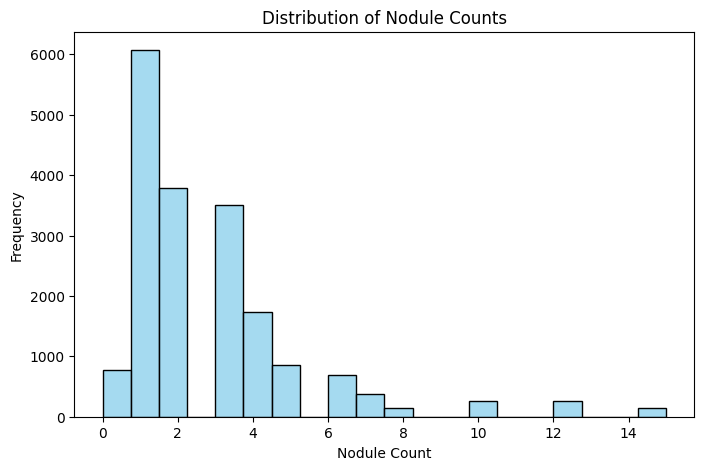

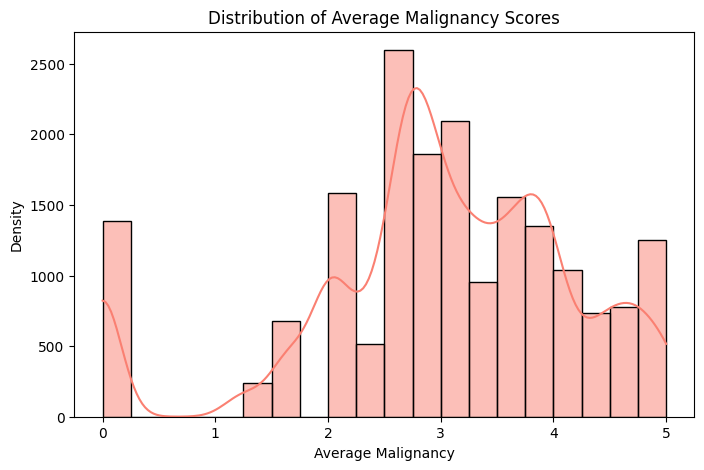

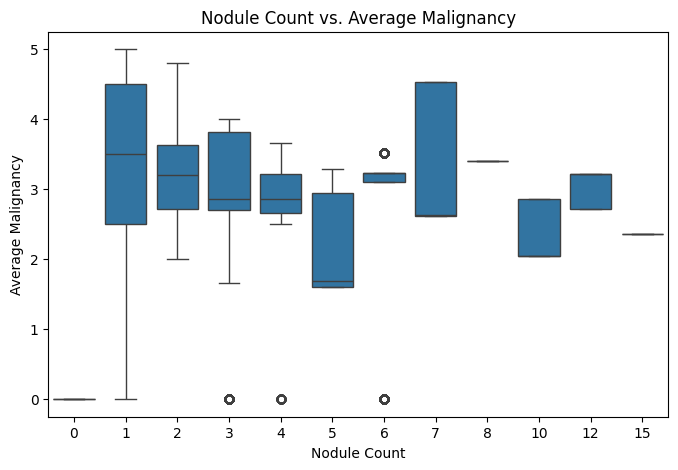

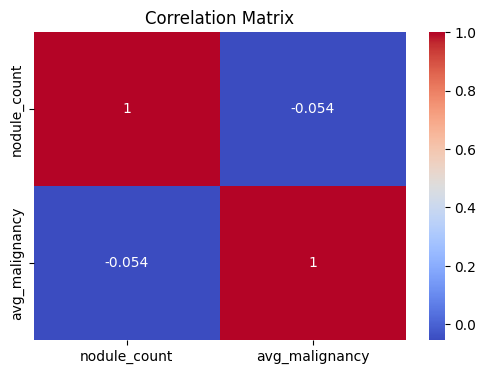

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/content/final_dataset.csv")

# Basic Info
print("📄 Dataset Overview:")
print(df.info())
print("\n🔢 Summary Statistics:")
print(df.describe())

# Check for missing values
print("\n🧩 Missing Values:")
print(df.isnull().sum())

# Plot Distribution of Nodule Counts
plt.figure(figsize=(8,5))
sns.histplot(df["nodule_count"], bins=20, kde=False, color='skyblue')
plt.title("Distribution of Nodule Counts")
plt.xlabel("Nodule Count")
plt.ylabel("Frequency")
plt.show()

# Plot Distribution of Average Malignancy
plt.figure(figsize=(8,5))
sns.histplot(df["avg_malignancy"], bins=20, kde=True, color='salmon')
plt.title("Distribution of Average Malignancy Scores")
plt.xlabel("Average Malignancy")
plt.ylabel("Density")
plt.show()

# Boxplot: Relationship between nodule count and malignancy
plt.figure(figsize=(8,5))
sns.boxplot(x="nodule_count", y="avg_malignancy", data=df)
plt.title("Nodule Count vs. Average Malignancy")
plt.xlabel("Nodule Count")
plt.ylabel("Average Malignancy")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df[["nodule_count", "avg_malignancy"]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


**Train-Validation-Test Split**

In [ ]:
import os
import pandas as pd

# Load dataset
csv_path = "/content/final_dataset.csv"

from sklearn.model_selection import train_test_split

# Load the cleaned dataset
df = pd.read_csv(csv_path)

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Save the split datasets
train_df.to_csv("train_dataset.csv", index=False)
val_df.to_csv("val_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

# Print verification
print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# Load and verify
train_df = pd.read_csv("train_dataset.csv")
val_df = pd.read_csv("val_dataset.csv")
test_df = pd.read_csv("test_dataset.csv")

# Sample data preview
print("\nSample from Train Dataset:")
print(train_df.head())


Train: 13036, Validation: 2793, Test: 2794

Sample from Train Dataset:
                                          image_path  nodule_count  \
0  /content/processed_images/LIDC-IDRI-0066/1-605...             3   
1  /content/processed_images/LIDC-IDRI-0083/1-101...             2   
2  /content/processed_images/LIDC-IDRI-0015/1-135...             1   
3  /content/processed_images/LIDC-IDRI-0044/1-098...             4   
4  /content/processed_images/LIDC-IDRI-0050/1-030...             1   

   avg_malignancy  
0        3.818182  
1        2.714286  
2        4.250000  
3        2.769231  
4        4.000000  


**Prepare Dataset Class and Dataloaders**

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

#  Load the dataset CSV files
train_df = pd.read_csv("train_dataset.csv")
val_df = pd.read_csv("val_dataset.csv")
test_df = pd.read_csv("test_dataset.csv")

#  Define Image Transformations (Resize, Normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for Swin Transformer
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet Normalization
])

# Custom Dataset Class
class LungCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row["image_path"]
        label = torch.tensor(row["avg_malignancy"], dtype=torch.float32)  # Regression label

        # Load and transform image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

#  Create Datasets & Dataloaders
batch_size = 32

train_dataset = LungCancerDataset(train_df, transform=transform)
val_dataset = LungCancerDataset(val_df, transform=transform)
test_dataset = LungCancerDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f" Data Preprocessing Complete! Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


 Data Preprocessing Complete! Train: 13036, Val: 2793, Test: 2794


**Train Swin Transformer Model**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.swin_transformer import swin_t  # Swin Transformer Tiny

#  Set device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

#  Load Pretrained Swin Transformer Model
model = swin_t(weights="DEFAULT")  # Load pre-trained weights
num_features = model.head.in_features
model.head = nn.Linear(num_features, 1)  # Modify final layer for regression

model = model.to(device)

#  Define Loss Function & Optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#  Training Loop
num_epochs = 10  # Adjust based on GPU availability
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()  # Remove extra dimension
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    #  Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f" Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

# Save Model
torch.save(model.state_dict(), "swin_lung_cancer.pth")
print(" Training Complete! Model saved as 'swin_lung_cancer.pth'")


 Using device: cuda


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 163MB/s] 


 Epoch 1/10: Train Loss: 0.5159 | Val Loss: 0.0513
 Epoch 2/10: Train Loss: 0.0679 | Val Loss: 0.0372
 Epoch 3/10: Train Loss: 0.0487 | Val Loss: 0.0808
 Epoch 4/10: Train Loss: 0.0359 | Val Loss: 0.0335
 Epoch 5/10: Train Loss: 0.0376 | Val Loss: 0.0884
 Epoch 6/10: Train Loss: 0.0560 | Val Loss: 0.0407
 Epoch 7/10: Train Loss: 0.0184 | Val Loss: 0.0177
 Epoch 8/10: Train Loss: 0.0317 | Val Loss: 0.0347
 Epoch 9/10: Train Loss: 0.0144 | Val Loss: 0.0195
 Epoch 10/10: Train Loss: 0.0097 | Val Loss: 0.0203
 Training Complete! Model saved as 'swin_lung_cancer.pth'


**Model Evaluation on Test Set**

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the test dataset
test_df = pd.read_csv("test_dataset.csv")

# Define Image Transformations (Same as Training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class (Same as Training)
class LungCancerDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row["image_path"]
        label = torch.tensor(row["avg_malignancy"], dtype=torch.float32)

        # Load and transform image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

# Load Test Dataset
test_dataset = LungCancerDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load Trained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models import swin_t
model = swin_t(weights=None)  # No pre-trained weights needed for evaluation
num_features = model.head.in_features
model.head = nn.Linear(num_features, 1)  # Modify final layer for regression
model.load_state_dict(torch.load("swin_lung_cancer.pth", map_location=device))
model = model.to(device)
model.eval()

#  Evaluate Model
actuals, predictions = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()

        actuals.extend(labels.cpu().numpy())
        predictions.extend(outputs.cpu().numpy())

# Compute Performance Metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f" Model Evaluation Results:")
print(f" Mean Squared Error (MSE): {mse:.4f}")
print(f" Mean Absolute Error (MAE): {mae:.4f}")
print(f" R² Score: {r2:.4f}")

# Display Sample Predictions
sample_results = list(zip(actuals[:10], predictions[:10]))
print("\n Sample Predictions:")
for idx, (true, pred) in enumerate(sample_results):
    print(f"Sample {idx+1}: Actual = {true:.2f}, Predicted = {pred:.2f}")


 Model Evaluation Results:
 Mean Squared Error (MSE): 0.0164
 Mean Absolute Error (MAE): 0.0726
 R² Score: 0.9890

 Sample Predictions:
Sample 1: Actual = 3.21, Predicted = 3.14
Sample 2: Actual = 3.82, Predicted = 3.90
Sample 3: Actual = 3.29, Predicted = 2.97
Sample 4: Actual = 2.75, Predicted = 2.65
Sample 5: Actual = 3.29, Predicted = 3.35
Sample 6: Actual = 3.44, Predicted = 3.48
Sample 7: Actual = 2.20, Predicted = 2.24
Sample 8: Actual = 2.00, Predicted = 2.07
Sample 9: Actual = 3.60, Predicted = 3.25
Sample 10: Actual = 3.40, Predicted = 3.44


**Visualize Predictions**

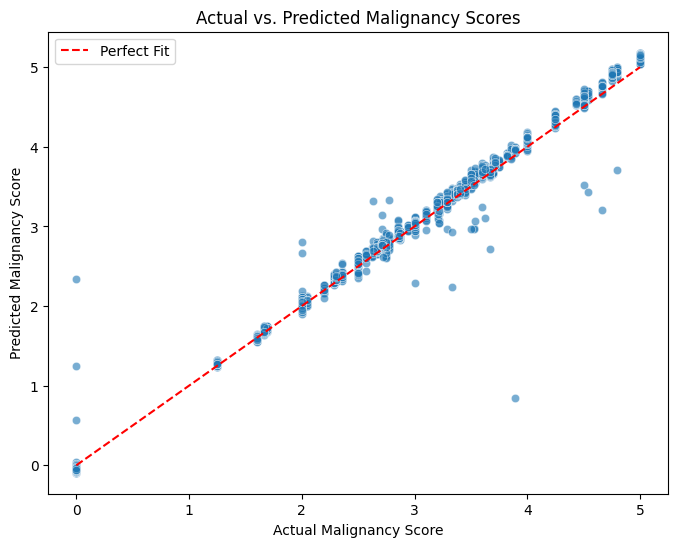

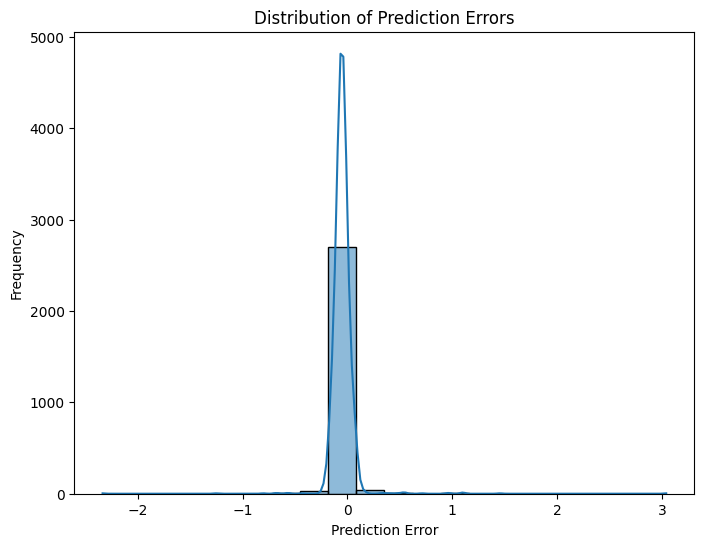

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert actuals & predictions to numpy arrays
actuals = np.array(actuals)
predictions = np.array(predictions)

# Scatter Plot: Actual vs. Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=actuals, y=predictions, alpha=0.6)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red', linestyle='dashed', label="Perfect Fit")
plt.xlabel("Actual Malignancy Score")
plt.ylabel("Predicted Malignancy Score")
plt.title("Actual vs. Predicted Malignancy Scores")
plt.legend()
plt.show()

# Histogram of Errors
errors = actuals - predictions
plt.figure(figsize=(8,6))
sns.histplot(errors, bins=20, kde=True)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()


**Predict on All Processed Images**

In [ ]:
import os
import torch
import torch.nn as nn
import pandas as pd
from torchvision import transforms
from PIL import Image
from torchvision.models import swin_t

# Load Trained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = swin_t(weights=None)  # No pre-trained weights, use our trained model
num_features = model.head.in_features
model.head = nn.Linear(num_features, 1)  # Modify final layer for regression
model.load_state_dict(torch.load("swin_lung_cancer.pth", map_location=device))
model = model.to(device)
model.eval()

# Define Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to Predict Malignancy for All Images in Subfolders
def predict_malignancy_from_folder(root_folder):
    results = []

    # Loop through all subfolders (LIDC-IDRI-0001, LIDC-IDRI-0002, ...)
    for patient_folder in sorted(os.listdir(root_folder)):
        patient_path = os.path.join(root_folder, patient_folder)
        if not os.path.isdir(patient_path):
            continue  # Skip non-directory files

        # Loop through images in the patient folder
        for file in sorted(os.listdir(patient_path)):
            if file.endswith(".png"):
                image_path = os.path.join(patient_path, file)

                # Load and preprocess image
                image = Image.open(image_path).convert("RGB")
                image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

                # Make prediction
                with torch.no_grad():
                    prediction = model(image).squeeze().item()

                results.append([patient_folder, image_path, prediction])

    # Convert results to a DataFrame and save
    df = pd.DataFrame(results, columns=["Patient_ID", "Image_Path", "Predicted_Malignancy"])
    output_csv = "predictions.csv"
    df.to_csv(output_csv, index=False)

    print(f"\n Predictions saved to {output_csv}")

image_folder = "processed_images"
predict_malignancy_from_folder(image_folder)
# Display first few predictions
print("\nSample Predictions:")
print(df.head())



 Predictions saved to predictions.csv

Sample Predictions:
                                          image_path  nodule_count  \
0  /content/processed_images/LIDC-IDRI-0098/1-006...             1   
1  /content/processed_images/LIDC-IDRI-0098/1-040...             1   
2  /content/processed_images/LIDC-IDRI-0098/1-036...             1   
3  /content/processed_images/LIDC-IDRI-0098/1-101...             1   
4  /content/processed_images/LIDC-IDRI-0098/1-098...             1   

   avg_malignancy  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
